# Data Sets

The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.) (10 offers x 6 columns)

profile.json - demographic data for each customer (17,000 customers x 5 columns)

transcript.json - records for customer response to offers and transactions made, offers received, offers viewed, and offers completed (306,648 events x 4 columns)
Here is the schema and explanation of each variable in the files:



# profile.json

     age (int) - age of the customer
     became_member_on (int) - date when customer created an app account
     gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
     id (str) - customer id
     income (float) - customer's income

# portfolio.json
    id (str) - offer id
    offer_type (str) - type of offer ie BOGO, discount, informational
    difficulty (int) - minimum required spend to complete an offer
    reward (int) - reward given for completing an offer
    duration (int) - time for offer to be open, in days
    channels (list of strings)

# transcript.json
    event (str) - record description (ie transaction, offer received, offer viewed, etc.)
    person (str) - customer id
    time (int) - time in hours since start of test. The data begins at time t=0
    value (str) - either an offer id or transaction amount depending on the record

# IMPORTING PACKAGES

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
from string import ascii_uppercase
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

# IMPORTING DATASETS

In [2]:
offer_df=pd.read_csv("portfolio.csv" , index_col=0)


In [3]:
profile_df=pd.read_csv("profile.csv" , index_col=0)


In [4]:
transcript_df=pd.read_csv("transcript.csv", index_col=0)

# PROFILE DATASET

In [5]:
profile_df

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


# Observation

# Profile Dataset

    became_member_on   is not in date format.
    gender             there are  2175 Missing values
    income             there are  2175 Missing values
    age                there are  2175 persons have 118 years it seems to be outlier. 
    id                 change his name to customer_id
    gender             need to encode
    become_member_on   need to encode

# 1. Data Wrangling

# 1.1 Data Cleaning

In [6]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 796.9+ KB


# Check for missing values

In [7]:
profile_df.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64



There are 2175 missing values in gender column and same 2175 missing values in income column in profile dataset.
Need to check whether these missing values are from the same observations.

# Age column - outliers value imputaion

In [8]:
profile_df['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
101       5
99        5
Name: age, Length: 85, dtype: int64

<AxesSubplot:xlabel='age'>

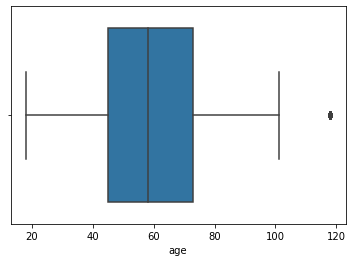

In [9]:
sns.boxplot(data=profile_df, x='age')

In [10]:

# profile_df[profile_df['age']==118]['gender'].value_counts()

from document 118 == null. impute with the average for each group in gender
find wich groups has null (118) in thier age

In [11]:
#find average age for 'other' group

average_age=np.round(profile_df.groupby('gender').mean().age.loc['O'])
average_age

54.0

In [12]:
#since all missing ages from the other group, use the average for the group

profile_df['age']= profile_df['age'].apply(lambda x : average_age if x == 118 else x)

In [13]:
profile_df['age'].value_counts()

54.0     2534
58.0      408
53.0      372
51.0      363
59.0      359
         ... 
100.0      12
96.0        8
98.0        5
101.0       5
99.0        5
Name: age, Length: 84, dtype: int64

# Gender column - missing value imputaion

In [14]:

profile_df['gender'].fillna("O", inplace=True)

In gender column group NaNs with "other", since we don't know thier gender

<AxesSubplot:xlabel='gender', ylabel='count'>

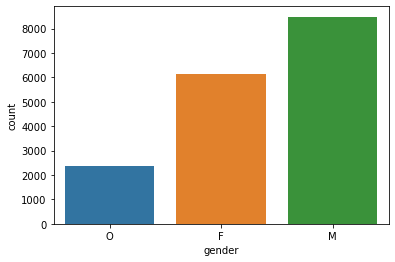

In [15]:
sns.countplot(data=profile_df,x='gender')

Male as more income than Female

In [16]:
profile_df['gender'].value_counts()

M    8484
F    6129
O    2387
Name: gender, dtype: int64

In [17]:
profile_df['gender'].value_counts(normalize=True)

M    0.499059
F    0.360529
O    0.140412
Name: gender, dtype: float64

# INCOME - missing value imputation

In [18]:
profile_df['income'].min(), profile_df['income'].max()

(30000.0, 120000.0)

Text(0.5, 1.0, 'Density distribution of Income')

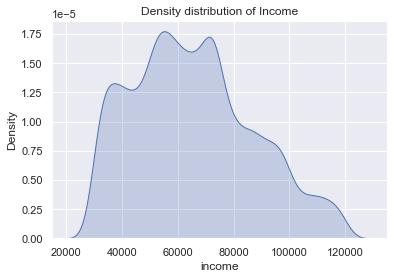

In [19]:
sns.set(style="darkgrid")
sns.kdeplot(data=profile_df['income'], shade=True)
plt.title('Density distribution of Income')

<AxesSubplot:xlabel='income'>

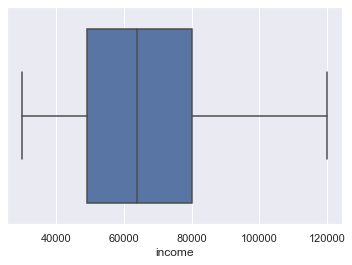

In [20]:
sns.boxplot(x='income', data=profile_df)

In [21]:
profile_df.groupby(['gender']).mean().income

gender
F    71306.412139
M    61194.601603
O    63287.735849
Name: income, dtype: float64

There are 2175 missing values in gender column and same 2175 missing values in income column in profile dataset.

These missing values are from the same observations.

Since we imputed our gender column has others gender, we impute missing values in income column with mean of same others gender.

In [22]:
average_income= np.round(profile_df.groupby('gender').mean().income.loc['O'])
average_income

63288.0

In [23]:
profile_df['income']= profile_df['income'].apply(lambda x : average_income if np.isnan(x) else x)

In [24]:
profile_df.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

Text(0.5, 1.0, 'Income per gender')

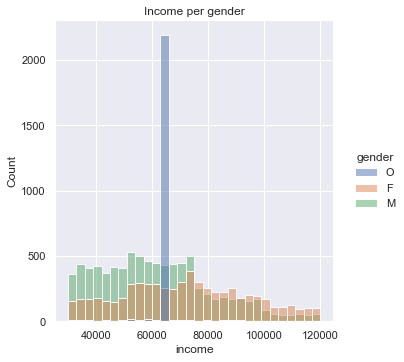

In [25]:
sns.displot(profile_df, x='income', hue='gender', bins=30)
plt.title('Income per gender')

all the missing income were from the 'other' group. 

# checking duplicate values

In [26]:
profile_df[profile_df.duplicated()]

,gender,age,id,became_member_on,income


There is no duplicate values

# changing date format 

In [27]:
profile_df['became_member_on'] = pd.to_datetime(profile_df['became_member_on'], format = '%Y%m%d')

In [28]:
profile_df['became_member_on']

0       2017-02-12
1       2017-07-15
2       2018-07-12
3       2017-05-09
4       2017-08-04
           ...    
16995   2018-06-04
16996   2018-07-13
16997   2017-01-26
16998   2016-03-07
16999   2017-07-22
Name: became_member_on, Length: 17000, dtype: datetime64[ns]

# extract only the year from 'became_member_on' and create column 'year'

In [29]:


profile_df['became_member_on_year']= profile_df['became_member_on'].apply(lambda x : str( x )[:4])
profile_df['became_member_on_year'].unique()

array(['2017', '2018', '2016', '2015', '2014', '2013'], dtype=object)

# see membership regstration throug the years

Text(0.5, 1.0, 'regestration per year')

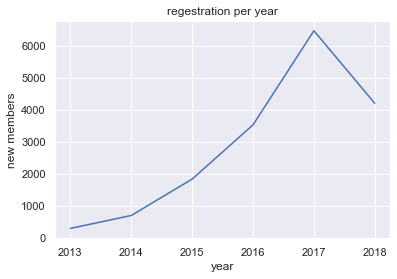

In [30]:

profile_df['became_member_on_year'].value_counts().sort_index().plot()
plt.xlabel('year')
plt.ylabel('new members')
plt.title('regestration per year')

Text(0.5, 1.0, 'Members joined frequency in years')

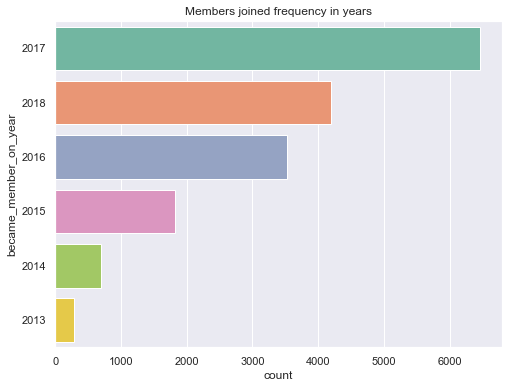

In [31]:
plt.figure(figsize=(8,6))

sns.set(style="darkgrid")
ax = sns.countplot(y="became_member_on_year", data=profile_df, palette="Set2", 
                   order=profile_df['became_member_on_year'].value_counts().index[0:15])
plt.title('Members joined frequency in years')

# Extracting month and day

In [32]:
profile_df['became_member_on_month'] = profile_df['became_member_on'].dt.month
profile_df['became_member_on_day_name']=profile_df['became_member_on'].dt.day_name()
profile_df['became_member_on_day']=profile_df['became_member_on'].dt.day

Text(0.5, 1.0, 'Members joined frequency by months')

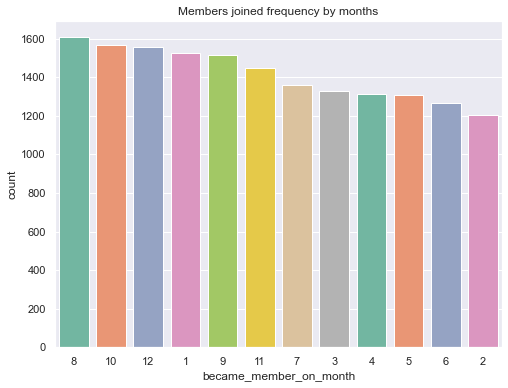

In [33]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
ax = sns.countplot(x="became_member_on_month", data=profile_df, palette="Set2", order=profile_df['became_member_on_month'].value_counts().index[0:15])
plt.title('Members joined frequency by months')

Text(0.5, 1.0, 'Members joined frequency by week-of-day')

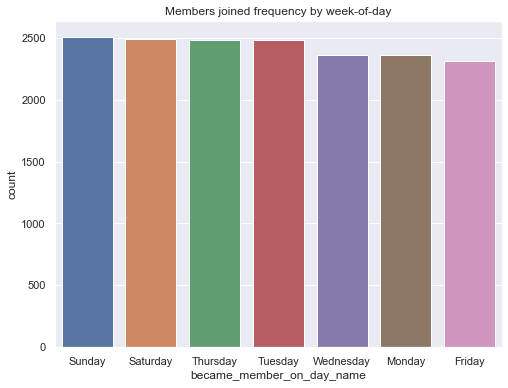

In [34]:
plt.figure(figsize=(8,6))
sns.set(style="darkgrid")
ax = sns.countplot(x="became_member_on_day_name", data=profile_df, 
                   order=profile_df['became_member_on_day_name'].value_counts().index[0:15])
plt.title('Members joined frequency by week-of-day')

In [35]:
profile_df['became_member_on_day'].value_counts()

25    601
20    597
7     592
13    591
21    589
17    583
26    579
10    577
24    572
19    567
28    567
15    560
2     558
23    557
12    554
11    554
1     551
29    551
8     549
16    546
27    541
6     541
14    540
22    539
5     537
9     528
4     523
18    514
30    506
3     506
31    330
Name: became_member_on_day, dtype: int64

# Changing id column name to customer_id

In [36]:
profile_df.rename(columns={'id': 'customer_id'}, inplace=True)

# BINNING

In [37]:
profile_df.age.min() , profile_df.age.max()

(18.0, 101.0)

min age is 18 and max age is 101

In [38]:
profile_df['age_group'] = pd.cut(x=profile_df['age'], bins=[18, 20, 40, 60, 80, 101],
                    labels=['0-19', '20-39', '40-59','60-70', '80-100'], include_lowest=True)


In [39]:
profile_df['age_group'].value_counts()

40-59     8156
60-70     4556
20-39     2962
80-100     986
0-19       340
Name: age_group, dtype: int64

Text(0.5, 1.0, 'Age-Group of staff at Starbucks')

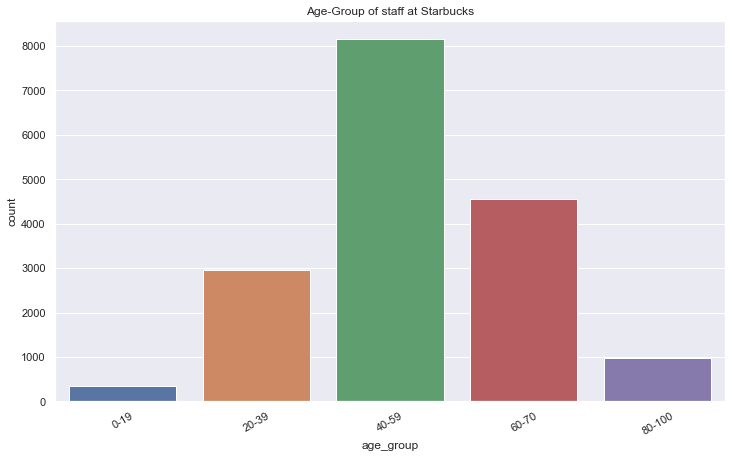

In [40]:
fig = plt.figure(figsize = (12,7))
sns.countplot(x='age_group',data=profile_df)
plt.xticks(rotation=30)
plt.title('Age-Group of staff at Starbucks')

# BIVARIATE ANALYSIS

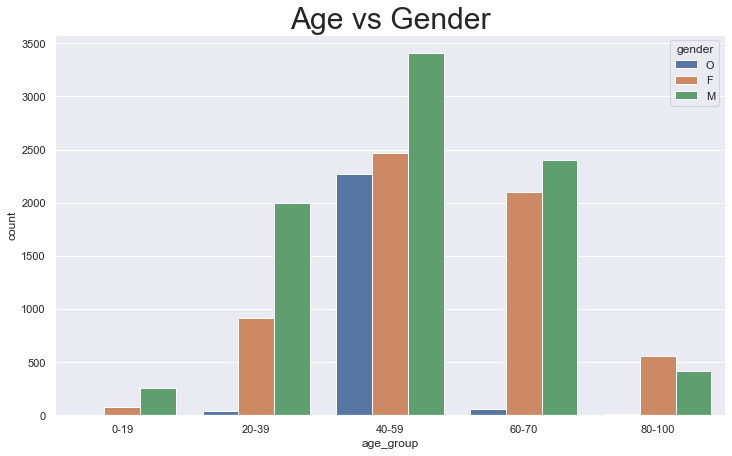

In [41]:
fig= plt.figure(figsize = (12,7))
sns.countplot(data = profile_df, x = 'age_group', hue = 'gender', fill = True)
plt.title('Age vs Gender', fontsize = 30)
plt.show()

In [42]:
print(profile_df.groupby('gender').agg({'income': 'mean'}))


              income
gender              
F       71306.412139
M       61194.601603
O       63287.976540


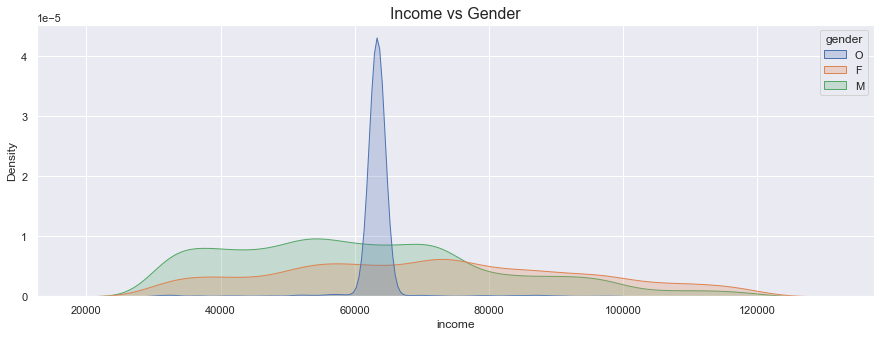

In [43]:
fig=plt.figure(figsize=(15,5))
sns.kdeplot(data = profile_df, x = 'income', hue = 'gender', fill = True)
plt.title('Income vs Gender', fontsize = 16)
plt.show()

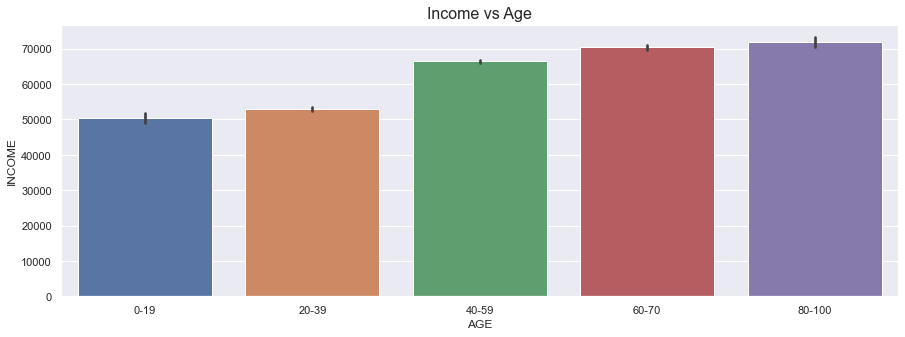

In [44]:
fig=plt.figure(figsize=(15,5))
sns.barplot(data = profile_df, x = 'age_group', y = 'income')
plt.xlabel("AGE")
plt.ylabel("INCOME")

plt.title('Income vs Age', fontsize = 16)
plt.show()

# from profile data

    People joined as member increased from 2015 and highest in 2017
    Highest number of people joined in August month
    Ofcourse Sunday and Saturday are the leading days in a week people joined.
    Income distribution is not skewed much, and is in the range of 50k-73k
    After imputing missing values, 50% of the staff are Male, 36% Female and 14% Others
    Highest proportion of staff at around 40% are in the age-group 40-59.

# ENCODING GENDER COLUMN

In [45]:

profile_df= pd.get_dummies(profile_df, columns = ['gender'], drop_first=True)

In [46]:
profile=profile_df
profile                  # saving in profile name after preproessing

,age,customer_id,became_member_on,income,became_member_on_year,became_member_on_month,became_member_on_day_name,became_member_on_day,age_group,gender_M,gender_O
0,54.0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,63288.0,2017,2,Sunday,12,40-59,0,1
1,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,Saturday,15,40-59,0,0
2,54.0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,63288.0,2018,7,Thursday,12,40-59,0,1
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,Tuesday,9,60-70,0,0
4,54.0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,63288.0,2017,8,Friday,4,40-59,0,1
...,...,...,...,...,...,...,...,...,...,...,...
16995,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,6,Monday,4,40-59,0,0
16996,61.0,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,7,Friday,13,60-70,1,0
16997,49.0,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,1,Thursday,26,40-59,1,0
16998,83.0,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,3,Monday,7,80-100,0,0


# OFFER DATASET

In [47]:
offer_df

,reward,channels,difficulty,duration,offer_type,id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5


# Observation

# Offer Dataset

    id            change his name to offer_id
    channels      need to encode
    offer_type    need to encode
    offer_id      create column has offer name like offer_1


In [48]:
offer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [49]:
offer_df=offer_df.rename({'id':'offer_id'})

In [50]:
df_offer = offer_df.sort_values(['offer_type', 'difficulty']).reset_index(drop = True)

# Add column `offer_alias`


offer_df['offer_alias'] = [ascii_uppercase[i] for i in range(df_offer.shape[0])]
offer_df

,reward,channels,difficulty,duration,offer_type,id,offer_alias
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,A
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,B
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,C
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,D
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,E
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,F
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,G
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,H
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,I
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,J


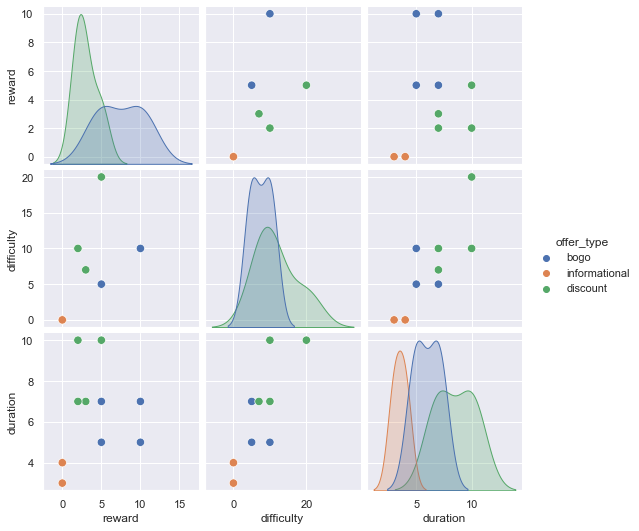

In [51]:
sns.pairplot(offer_df, hue = 'offer_type', 
             plot_kws = dict(marker="o", s=70),); plt.show()

# Observations

    There are 4 'bogo' offers (i.e. buy one get one), 4 'discount' offers and 2 'informational' offers.
    'Discount' offers tend to have the longest duration, followed by 'bogo' offers. 'Informational' offers have the shortest duration.
    'Discount' offers tend to have higher difficulty but lower rewards compared with 'bogo' offers.
    Offer difficulty seems to be possitively correlated with offer reward.
    Offer duration seems to negatively correlate with reward and positively correlate with difficulty, when 'informational'         offers are exclued (they don't really have reward or difficulty).

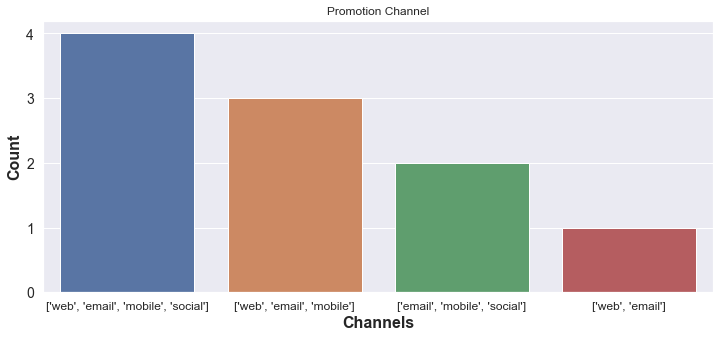

In [52]:
p = offer_df.value_counts('channels')

plt.figure(figsize = (12,5))
sns.barplot(x = p.index.values, y = p.values)
plt.xticks(rotation = None, fontsize = 12)
plt.yticks(np.arange(5), fontsize = 14)
plt.xlabel('Channels', fontsize = 16, fontweight = 'bold')
plt.ylabel('Count', fontsize = 16, fontweight = 'bold')
plt.title('Promotion Channel')
plt.show()

# Observations

Offers were sent to customers through combinations of 4 types of promotion channels websites, email, mobile App and social. There are 4 combinations of channels used by the 10 offers. Promotional effect of each channel can be extracted from comparisons between offers using different channels.

    4 offers used all channels (blue).
    3 offers used all channels except for social meida (orange). Promotional effect of social media could be extract from certain forms of comparison between these offers with offers using all channels.
    2 offers used all channels except for websites (green). Promotional effect of websites could be extract from comparison between these offers with offers using all channels.
    2 offers only used websites and email (red). Promotional effect of mobile App can be extracted from comparison between these offer with offers in the orange group. Moreover, as the effect of websites can be derived from other comparisons, promotional effect of emails can also be extracted.

In [53]:
offer_df['channels'].value_counts()

['web', 'email', 'mobile', 'social']    4
['web', 'email', 'mobile']              3
['email', 'mobile', 'social']           2
['web', 'email']                        1
Name: channels, dtype: int64

In [54]:
channels_df = offer_df.groupby(['id','channels']).mean().reset_index()
channels_df

,id,channels,reward,difficulty,duration
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,"['web', 'email']",5.0,20.0,10.0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,"['web', 'email', 'mobile', 'social']",3.0,7.0,7.0
2,2906b810c7d4411798c6938adc9daaa5,"['web', 'email', 'mobile']",2.0,10.0,7.0
3,3f207df678b143eea3cee63160fa8bed,"['web', 'email', 'mobile']",0.0,0.0,4.0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,"['web', 'email', 'mobile', 'social']",10.0,10.0,5.0
5,5a8bc65990b245e5a138643cd4eb9837,"['email', 'mobile', 'social']",0.0,0.0,3.0
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5.0,5.0,7.0
7,ae264e3637204a6fb9bb56bc8210ddfd,"['email', 'mobile', 'social']",10.0,10.0,7.0
8,f19421c1d4aa40978ebb69ca19b0e20d,"['web', 'email', 'mobile', 'social']",5.0,5.0,5.0
9,fafdcd668e3743c1bb461111dcafc2a4,"['web', 'email', 'mobile', 'social']",2.0,10.0,10.0


In [55]:
offer_encoded = pd.get_dummies(offer_df, columns=['channels','offer_type'])


In [56]:
offer_encoded

,reward,difficulty,duration,id,offer_alias,"channels_['email', 'mobile', 'social']","channels_['web', 'email', 'mobile', 'social']","channels_['web', 'email', 'mobile']","channels_['web', 'email']",offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,A,1,0,0,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,B,0,1,0,0,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,C,0,0,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,D,0,0,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,E,0,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,F,0,1,0,0,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,G,0,1,0,0,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,H,1,0,0,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,I,0,1,0,0,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,J,0,0,1,0,0,1,0


In [57]:
offer_df

,reward,channels,difficulty,duration,offer_type,id,offer_alias
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,A
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,B
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,C
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,D
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,E
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,F
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,G
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,H
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,I
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,J


# CHANNELS Vs DURATION

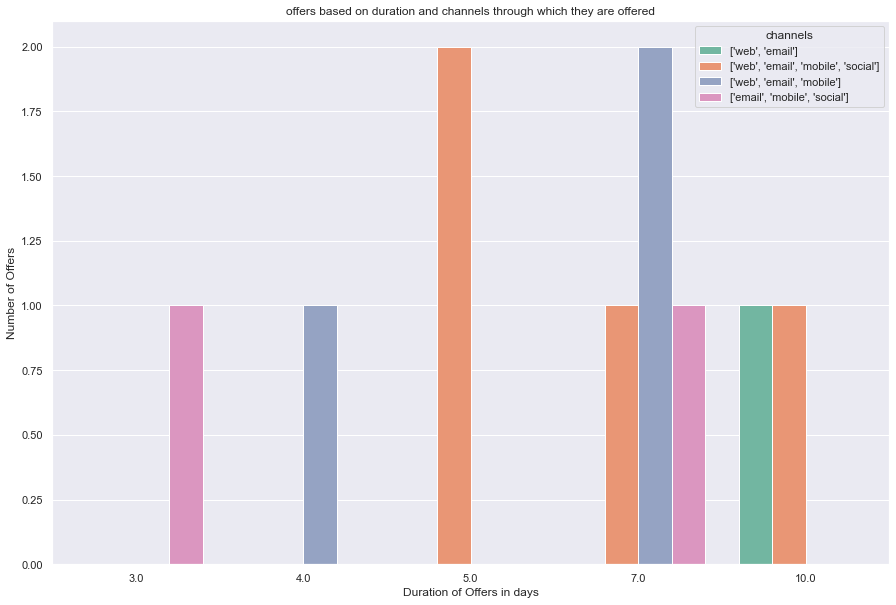

In [58]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="duration", data=channels_df, palette="Set2", hue='channels')
plt.ylabel('Number of Offers')
plt.xlabel('Duration of Offers in days')
plt.title('offers based on duration and channels through which they are offered')
plt.show()

# CHANNELS Vs DIFFICULTY

Text(0.5, 1.0, 'Offers based on difficulty and channels through which they are offered')

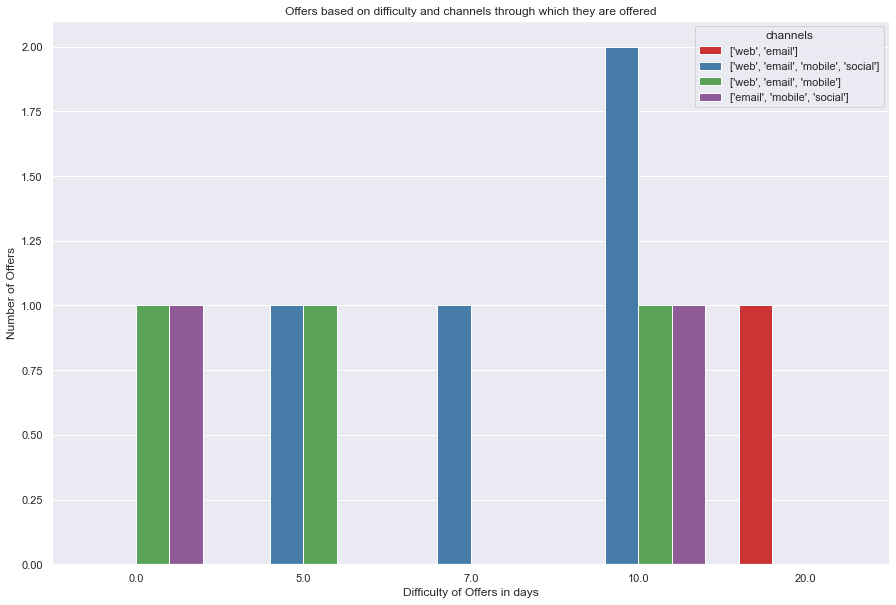

In [59]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="difficulty", data=channels_df, palette="Set1", hue='channels')
plt.ylabel('Number of Offers')
plt.xlabel('Difficulty of Offers in days')
plt.title('Offers based on difficulty and channels through which they are offered')

# Types of Discounts on Offers

In [60]:
pie_df = offer_df.offer_type.value_counts().reset_index().offer_type

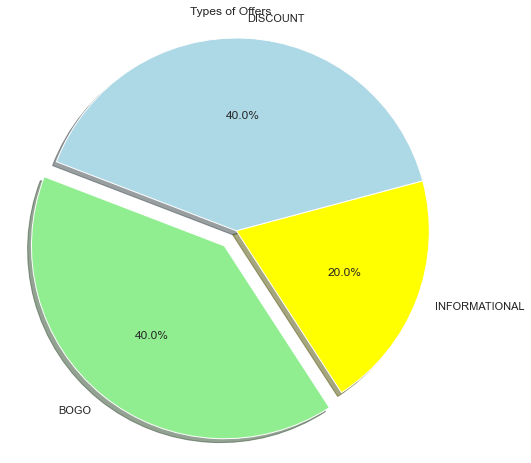

In [61]:
plt.figure(figsize=(8,8))
labels = 'DISCOUNT','BOGO','INFORMATIONAL'
colors = ['lightblue','lightgreen','yellow']
explode = (0, 0.1, 0)
plt.pie(pie_df, labels=labels, autopct='%1.1f%%', startangle=15, shadow = True, colors=colors, explode=explode)
plt.title('Types of Offers')
plt.axis('equal')
plt.show()

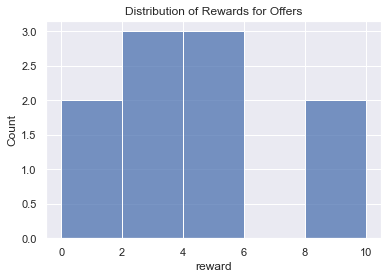

In [62]:
sns.histplot(offer_df, x="reward")
plt.title('Distribution of Rewards for Offers')
plt.show()

<AxesSubplot:xlabel='difficulty'>

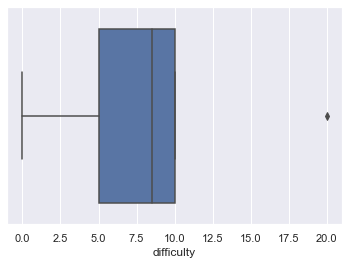

In [63]:
sns.boxplot(data=offer_df,x='difficulty')

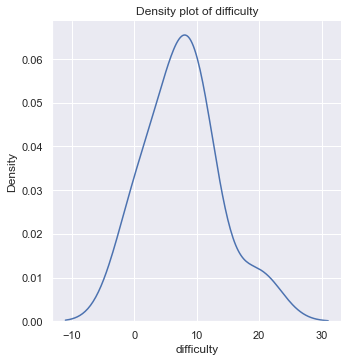

In [64]:
sns.displot(offer_df, x="difficulty", kind="kde")
plt.title('Density plot of difficulty')
plt.show()

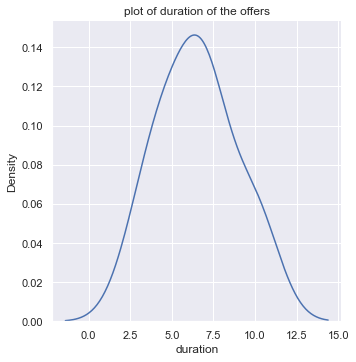

In [65]:
sns.set_theme(style="darkgrid")
sns.displot(offer_df, x="duration", kind="kde")
plt.title('plot of duration of the offers')
plt.show()

In [66]:
offer_encoded= offer_encoded.rename(columns={'id':'offer_id'})

In [67]:
offer_encoded

,reward,difficulty,duration,offer_id,offer_alias,"channels_['email', 'mobile', 'social']","channels_['web', 'email', 'mobile', 'social']","channels_['web', 'email', 'mobile']","channels_['web', 'email']",offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,A,1,0,0,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,B,0,1,0,0,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,C,0,0,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,D,0,0,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,E,0,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,F,0,1,0,0,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,G,0,1,0,0,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,H,1,0,0,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,I,0,1,0,0,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,J,0,0,1,0,0,1,0


# TRANSCRIPT DATASET

In [68]:
transcript_df.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [69]:
transcript_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 11.7+ MB


# Observation

# Transcript Dataset

    time   convert to days
    person change his name to id
    value  extract offer_id and amount
    event  need to encode

In [70]:
transcript_df=transcript_df.rename(columns={"person":"customer_id"})
transcript_df

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [71]:
transcript_df['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [72]:
transcript_df['event'].value_counts(normalize=True)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

C:\Users\Ashok\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='event', ylabel='count'>

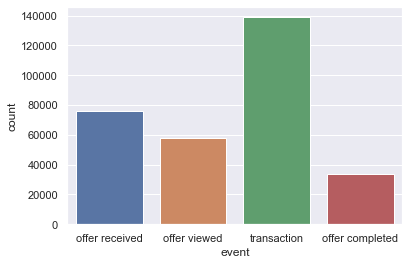

In [73]:
sns.countplot(transcript_df['event'])

# Binning time intervals

In [74]:
transcript_df['time'].value_counts()

408    17030
576    17015
504    16822
336    16302
168    16150
       ...  
318      940
330      938
156      914
162      910
150      894
Name: time, Length: 120, dtype: int64

In [75]:
transcript_df.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714], dtype=int64)

In [76]:
transcript_df['time_group'] = pd.cut(x=transcript_df['time'], bins=[0, 100, 200, 300, 400, 500,600,700,800], include_lowest=True,
          labels=['0-100 days', '100-200 days', '200-300 days', '300-400 days', '400-500 days', '500-600 days', '600-700 days', '700-800 days'])

Text(0.5, 1.0, 'No. of offers in the Timespan')

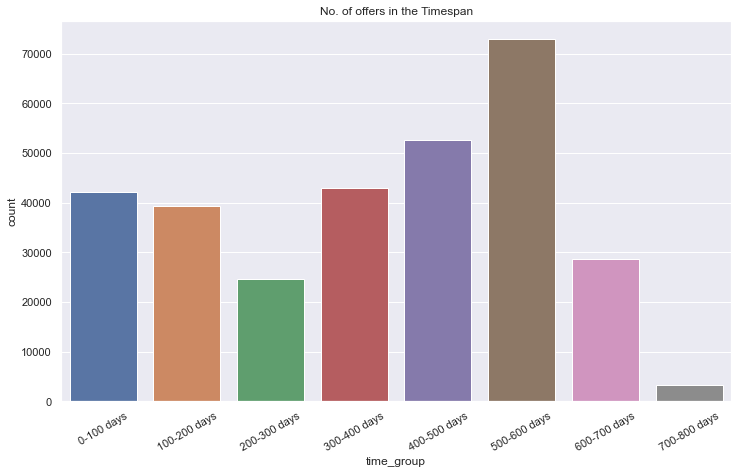

In [77]:
fig = plt.figure(figsize = (12,7))
sns.countplot(x='time_group',data=transcript_df)
plt.xticks(rotation=30)
plt.title('No. of offers in the Timespan')

In [78]:
offers_received_df = transcript_df[transcript_df.event == 'offer received']
offers_received_df

,customer_id,event,value,time,time_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0-100 days
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0-100 days
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0-100 days
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0-100 days
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0-100 days
...,...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,500-600 days
257883,cb23b66c56f64b109d673d5e56574529,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576,500-600 days
257884,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576,500-600 days
257885,9dc1421481194dcd9400aec7c9ae6366,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,500-600 days


In [79]:
transcript_df.customer_id.value_counts() 

94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
d0a80415b84c4df4908b8403b19765e3    48
5e60c6aa3b834e44b822ea43a3efea26    48
79d9d4f86aca4bed9290350fb43817c2    48
                                    ..
afd41b230f924f9ca8f5ed6249616114     2
3a4e53046c544134bb1e7782248631d1     2
e63e42480aae4ede9f07cac49c8c3f78     2
7ecfc592171f4844bdc05bdbb48d3847     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: customer_id, Length: 17000, dtype: int64

In [80]:
offers_viewed_df = transcript_df[transcript_df.event == 'offer viewed']
offers_viewed_df

,customer_id,event,value,time,time_group
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,0-100 days
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0-100 days
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0-100 days
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,0-100 days
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0-100 days
...,...,...,...,...,...
306441,d56386cf344c4829bbf420d1895dca37,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714,700-800 days
306450,9b51e8797290403b90d09d864dec4b94,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714,700-800 days
306483,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714,700-800 days
306490,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714,700-800 days


In [81]:
offers_completed_df = transcript_df[transcript_df.event == 'offer viewed']
offers_completed_df

,customer_id,event,value,time,time_group
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,0-100 days
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0-100 days
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0-100 days
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,0-100 days
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0-100 days
...,...,...,...,...,...
306441,d56386cf344c4829bbf420d1895dca37,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714,700-800 days
306450,9b51e8797290403b90d09d864dec4b94,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714,700-800 days
306483,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714,700-800 days
306490,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714,700-800 days


In [82]:
offer_completed_people = offers_received_df.isin(list(offers_completed_df['customer_id']))
offers_received_df[offer_completed_people['customer_id']]

,customer_id,event,value,time,time_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0-100 days
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0-100 days
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0-100 days
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0-100 days
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0-100 days
...,...,...,...,...,...
257881,a57890c3bbb7463e9018abb7fecadb15,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},576,500-600 days
257882,d087c473b4d247ccb0abfef59ba12b0e,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,500-600 days
257884,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576,500-600 days
257885,9dc1421481194dcd9400aec7c9ae6366,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,500-600 days


# SPLITTING VALUE COLUMN

In [83]:
import ast
def string_to_dict(val):
    return ast.literal_eval(val)

transcript_df.value = transcript_df.value.apply(string_to_dict)

In [84]:
keys = []

def get_keys(val):
    if list(val.keys()) not in keys:
        keys.append(list(val.keys()))
    
    
transcript_df.value.apply(get_keys)

keys = [ item for elem in keys for item in elem]
print(keys)

['offer id', 'amount', 'offer_id', 'reward']


In [85]:
def split_key(val):
    if list(val.keys())[0].startswith(key[:2]):
        return list(val.values())[0]
    else:
        return 0
    

In [86]:
for key in keys[1:3]:
    transcript_df[key] = transcript_df.value.apply(split_key)

In [87]:
transcript_df.drop('value', axis=1, inplace=True)

# ENCODING EVENT COLUMN

In [88]:
transcript_df = pd.concat([transcript_df,pd.get_dummies(transcript_df["event"])],axis=1)

In [89]:
# transcript_df.drop(['event'],axis=1, inplace=True)

In [90]:
transcript_df

,customer_id,event,time,time_group,amount,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0-100 days,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0-100 days,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0-100 days,0.00,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0-100 days,0.00,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0-100 days,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,700-800 days,1.59,0,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,700-800 days,9.53,0,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,transaction,714,700-800 days,3.61,0,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,700-800 days,3.53,0,0,0,0,1


# Create successful offer column¶
Note: that the offer be success if a customer completed an offer and viewed it and if not viewed the offer become not success offer

In [91]:
# check if the offer is success or not

# Group-by value counts in event column 

offer_customer = transcript_df.pivot_table(index=['customer_id','offer_id'],\
                 columns='event', aggfunc='size', fill_value=0)

offer_customer.reset_index(level=[0,1], inplace=True)

In [92]:
# creat successful_offer column 

offer_customer['successful_offer'] =\
    offer_customer['offer completed'] * offer_customer['offer viewed']

offer_customer['successful_offer'] = offer_customer['successful_offer'].apply(lambda x: 1 if x > 0 else 0)

In [93]:
offer_customer

event,customer_id,offer_id,offer completed,offer received,offer viewed,transaction,successful_offer
0,0009655768c64bdeb2e877511632db8f,0,0,0,0,8,0
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,0
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0,0
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,0
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,0,1
...,...,...,...,...,...,...,...
79861,ffff82501cea40309d5fdd7edcca4a07,0,0,0,0,15,0
79862,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,0,1
79863,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,3,3,0,1
79864,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1


# MERGING TO DATASETS BASED ON PERSON ID

# create overall dataset that a combination from offer_customer dataset and profile dataset and portoflio dataset

In [94]:


overall_df = pd.merge(offer_customer,offer_encoded,on='offer_id', how='left')


In [95]:
overall_df = pd.merge(overall_df,profile,on='customer_id')
overall_df

,customer_id,offer_id,offer completed,offer received,offer viewed,transaction,successful_offer,reward,difficulty,duration,...,age,became_member_on,income,became_member_on_year,became_member_on_month,became_member_on_day_name,became_member_on_day,age_group,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,0,0,0,0,8,0,NaN,NaN,NaN,...,33.0,2017-04-21,72000.0,2017,4,Friday,21,20-39,1,0
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,0,2.0,10.0,7.0,...,33.0,2017-04-21,72000.0,2017,4,Friday,21,20-39,1,0
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0,0,0.0,0.0,4.0,...,33.0,2017-04-21,72000.0,2017,4,Friday,21,20-39,1,0
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,0,0.0,0.0,3.0,...,33.0,2017-04-21,72000.0,2017,4,Friday,21,20-39,1,0
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,0,1,5.0,5.0,5.0,...,33.0,2017-04-21,72000.0,2017,4,Friday,21,20-39,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79861,ffff82501cea40309d5fdd7edcca4a07,0,0,0,0,15,0,NaN,NaN,NaN,...,45.0,2016-11-25,62000.0,2016,11,Friday,25,40-59,0,0
79862,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,0,1,5.0,20.0,10.0,...,45.0,2016-11-25,62000.0,2016,11,Friday,25,40-59,0,0
79863,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,3,3,0,1,2.0,10.0,7.0,...,45.0,2016-11-25,62000.0,2016,11,Friday,25,40-59,0,0
79864,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,5.0,5.0,7.0,...,45.0,2016-11-25,62000.0,2016,11,Friday,25,40-59,0,0


In [96]:
overall_df[overall_df.duplicated()]

,customer_id,offer_id,offer completed,offer received,offer viewed,transaction,successful_offer,reward,difficulty,duration,...,age,became_member_on,income,became_member_on_year,became_member_on_month,became_member_on_day_name,became_member_on_day,age_group,gender_M,gender_O


In [97]:
overall_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79866 entries, 0 to 79865
Data columns (total 28 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   customer_id                                    79866 non-null  object        
 1   offer_id                                       79866 non-null  object        
 2   offer completed                                79866 non-null  int64         
 3   offer received                                 79866 non-null  int64         
 4   offer viewed                                   79866 non-null  int64         
 5   transaction                                    79866 non-null  int64         
 6   successful_offer                               79866 non-null  int64         
 7   reward                                         63288 non-null  float64       
 8   difficulty                                     63288 non

In [98]:
x=overall_df.loc[:,['offer completed','offer viewed','offer received','transaction']]

In [99]:
x.fillna(0)

,offer completed,offer viewed,offer received,transaction
0,0,0,0,8
1,1,0,1,0
2,0,1,1,0
3,0,1,1,0
4,1,1,1,0
...,...,...,...,...
79861,0,0,0,15
79862,1,1,1,0
79863,3,3,3,0
79864,1,1,1,0


In [100]:
scaler = StandardScaler()
scaled_x=scaler.fit_transform(x)
scaled_x

array([[-0.69267363, -1.09443011, -1.50624074,  1.52890829],
       [ 0.95481653, -1.09443011,  0.07087193, -0.42491403],
       [-0.69267363,  0.41977959,  0.07087193, -0.42491403],
       ...,
       [ 4.24979684,  3.448199  ,  3.22509725, -0.42491403],
       [ 0.95481653,  0.41977959,  0.07087193, -0.42491403],
       [ 0.95481653,  0.41977959,  0.07087193, -0.42491403]])

In [101]:
kmeans = KMeans(init="random", n_clusters=3, n_init=10,max_iter=300,random_state=42)

In [102]:
kmeans.fit(scaled_x)
KMeans(init='random', n_clusters=3, random_state=42)

KMeans(init='random', n_clusters=3, random_state=42)

In [103]:
kmeans.inertia_


123166.95378963534

In [104]:
kmeans.cluster_centers_

array([[ 1.21402907,  0.44670908,  0.45446895, -0.42491403],
       [-0.69267363,  0.15121214,  0.34383196, -0.42491403],
       [-0.69267363, -1.09443011, -1.50624074,  1.62214738]])

In [105]:
kmeans.n_iter_

5

# Choosing the Appropriate Number of Clusters
     The elbow method
     The silhouette coefficient

# ELBOW METHOD

In [106]:
kmeans_kwargs = { "init": "random","n_init": 10, "max_iter": 300, "random_state": 42}
  
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_x)
    sse.append(kmeans.inertia_)


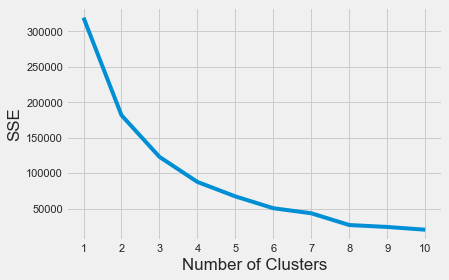

In [107]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [108]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow


4

In [110]:
kmeans.cluster_centers_

array([[-0.30821104,  1.74388219,  1.81386527, -0.42491403],
       [ 0.95481653,  0.41977959,  0.1058879 , -0.42491403],
       [-0.69267363,  0.41977959,  0.07087193, -0.42491403],
       [ 1.05641419, -1.09443011,  0.28602816, -0.42491403],
       [ 2.62383027,  1.62005204,  1.70218244, -0.42491403],
       [-0.69267363, -1.09443011, -1.50624074,  0.79417427],
       [-0.69267363, -1.09443011,  0.26017794, -0.42491403],
       [-0.69267363, -1.09443011, -1.50624074,  4.20443412],
       [ 3.92675956,  3.34428265,  3.38358161, -0.42491403],
       [-0.69267363, -1.09443011, -1.50624074,  2.36460605]])

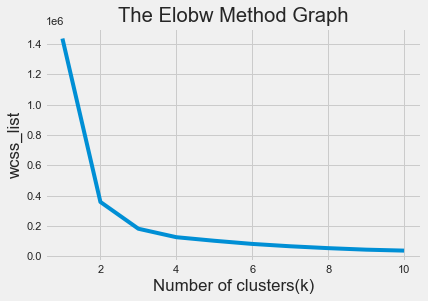

In [112]:
wcss_list= []  #Initializing the list for the values of WCSS  
  
#Using for loop for iterations from 1 to 10.  
for i in range(1, 11):  
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state= 42)  
    kmeans.fit(x)  
    wcss_list.append(kmeans.inertia_)  

plt.plot(range(1, 11), wcss_list)  
plt.title('The Elobw Method Graph')  
plt.xlabel('Number of clusters(k)')  
plt.ylabel('wcss_list')  
plt.show()  

In [113]:
#training the K-means model on a dataset 

kmeans = KMeans(n_clusters=5, init='k-means++', random_state= 42)  
y_predict= kmeans.fit_predict(x)  